# Import all packages

In [5]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import unidecode as unidecode

import spacy
from spacy.matcher import Matcher
from spacy.lang.en.stop_words import STOP_WORDS
from spacy import displacy
from spacy.matcher import Matcher
import textacy 
from gensim.models import FastText
from gensim.test.utils import get_tmpfile
from gensim.utils import tokenize
import gensim.downloader as api
from tqdm.notebook import tqdm_notebook
import pickle

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

In [6]:
nlp = spacy.load("en_core_web_sm", parse=True, tag=True, entity=True)

# Load documents 
Load in metadata.csv, note that all the meta data are clean by following:

<b>Metadata clean</b>
- Removing abstract that doesn't contain information.
- Combining title and abstract into single column
- Calculate document vectors using FastText, load "glove-wiki-gigaword-50" model

    - Note that this document model can be change e.g. more complex model, or use ELMO or BERT.
    
    - "df_vectors" should be recomputed when model is changed.
    
<b>Metadata vector</b>
- Calculate similarity vectors between documents
- Using this similarity vectors to form knowledge graph
- Using knowledge graph to find:
    - Degree centrality: Measures number of incoming connections, nodes with highest connection are important ones
    - Closeness Centrality: Measures minimum numbers of steps can one nodes connect to others in the network
    - EigenVector Centrality: Measures a node connection to those who are highly connected. Influencing nodes and exercising control
    - Betweenness Centrality: Measure of centrality in a graph based on shortest paths. Bridge Nodes, how important node is to the shortest path through the network. 
    
    

In [7]:
# Load CSV clean and vectors 
ori_df = pd.read_csv(os.path.join("Corpus", "metadata.csv"))
df = pd.read_csv(os.path.join("Corpus", "metadata_clean.csv"))
df_vectors = pd.read_csv(os.path.join("Corpus", "metadata_vectors.csv"))

print(f"Total number of documents: {df.shape}")
print(f"Vectors shape: {df_vectors.shape}")

Total number of documents: (35151, 3)
Vectors shape: (35151, 300)


# Loading model and functions

In [8]:
def contain_word(word):
    return word in model.vocab.keys()

def sentence_vector(sentence, negative=None, positive=None):
    """
    Use either negative or positive sentences to guide sentence vector
    """
    if negative:
        negative = list(tokenize(negative))
        negative = [word for word in negative if word not in sentence]
        # print(negative)
        neg_vectors = [model[word] for word in negative if contain_word(word)]
        
        # tokenize sentence, we need sentence as a string to extract additional words in negative
        sentence = list(tokenize(sentence))
        vectors = [model[word] for word in sentence if contain_word(word)]
        vectors = np.mean(vectors, axis=0)
        
        if len(neg_vectors) == 0:
            neg_vectors = np.zeros(vectors.shape)
                   
        return vectors - np.mean(neg_vectors, axis=0)
    
    elif positive:
        positive = list(tokenize(positive))
        positive = [word for word in positive if word not in sentence]
        # print(positive)
        pos_vectors = [model[word] for word in positive if contain_word(word)]
        
        # tokenize sentence, we need sentence as a string to extract additional words in positive
        sentence = list(tokenize(sentence))
        vectors = [model[word] for word in sentence if contain_word(word)]
        vectors = np.mean(vectors, axis=0)
        
        if len(pos_vectors) == 0:
            pos_vectors = np.zeros(vectors.shape)
        
        return vectors + np.mean(pos_vectors, axis=0)
    
    else:
        sentence = list(tokenize(sentence))
        vectors = [model[word] for word in sentence if contain_word(word)]
        return np.mean(vectors, axis=0)

def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return len(intersection)/len(union)

def search_doc(query, context=None, top_n=100):
    query_vector = sentence_vector(query, positive=context)
    result = model.cosine_similarities(query_vector, df_vectors.values)
    df['score'] = result 
    return df.sort_values('score', ascending=False)[:top_n]


In [9]:
# model = api.load("glove-wiki-gigaword-50", return_path=False)
model = api.load("fasttext-wiki-news-subwords-300", return_path=False)

# Building knowledge graph through query sentence

## Query sentence compute distance score with all content
"search_doc" function is design to allow users to add context to search query. It allow us to guide the vector towards a certain direction.

In exmaple following query:
- Computer virus is infecting every city. context="digital"
- Coronavirus is infecting every city. context="biology"

Because our model does not know the new word coronavirus, we can provide context to the search. The result will be more accurate than the query alone.


In [48]:
model.most_similar(["diagnose", "medical"])

[('diagnostic', 0.7502744197845459),
 ('medicalize', 0.7201535701751709),
 ('self-diagnose', 0.7193400263786316),
 ('medicial', 0.7189865112304688),
 ('diagnosis', 0.7184364795684814),
 ('diagnoses', 0.7170848846435547),
 ('physicial', 0.7164655923843384),
 ('misdiagnose', 0.7160506248474121),
 ('telemedical', 0.7155623435974121),
 ('medicalise', 0.7101578712463379)]

In [443]:
result_df = search_doc("New diagnostic methods and products to improve clinical processes.", context="medical, pneumonia, fast, test kit", top_n=1000)
result_df

,title,abstract,content,score
4661,Rapid syndromic molecular testing in pneumonia...,"Summary Community acquired pneumonia (CAP), ho...",Rapid syndromic molecular testing in pneumonia...,0.914594
27070,Infection on a chip: a microscale platform for...,The plaque assay has long served as the “gold ...,Infection on a chip: a microscale platform for...,0.905912
19556,Geospatial Science and Point-of-Care Testing: ...,Objectives: (a) To understand how to integrate...,Geospatial Science and Point-of-Care Testing: ...,0.904277
24212,Clinical Microbiology Informatics.,SUMMARY: The clinical microbiology laboratory ...,Clinical Microbiology Informatics. SUMMARY: Th...,0.904100
33840,Plasmonic silver nanoshells for drug and metab...,In-vitro metabolite and drug detection rely on...,Plasmonic silver nanoshells for drug and metab...,0.904050
...,...,...,...,...
18020,Major medical causes by breed and life stage f...,BACKGROUND: Age and breed are considered the g...,Major medical causes by breed and life stage f...,0.878808
2564,Ebola Virus Disease Ethics and Emergency Medic...,Caring for patients affected with Ebola virus ...,Ebola Virus Disease Ethics and Emergency Medic...,0.878806
18970,Research in epidemic and emergency situations:...,Various forms of research are essential in eme...,Research in epidemic and emergency situations:...,0.878789
17336,Mapping infectious disease hospital surge thre...,BACKGROUND: Hospital usage and service demand ...,Mapping infectious disease hospital surge thre...,0.878775


## Calculate the edges
Each id is a document, edges is how closely the document is related to one another.

We are using min-max scaler because the document is already closely related by using min-max scaler minor different will scale up. 

The purpose is to further group them and see there are any nodes cluster to be found. We can later use centrality algorithm to further find import links between these documents.

In [11]:
from sklearn import preprocessing

In [444]:
dis_matrix = []

# Filter selected vectors
df_result_vectors = df_vectors.iloc[result_df.index]

# Compute similarity vector matrix against each document
for idx, row in tqdm_notebook(df_result_vectors.iterrows(), total=len(df_result_vectors)):
    row = list(row)
    result = model.cosine_similarities(row, df_result_vectors)
    dis_matrix.append(result)
    
# Scale the result 
min_max_scaler = preprocessing.MinMaxScaler()
dis_matrix = min_max_scaler.fit_transform(dis_matrix)
dis_matrix_df = pd.DataFrame(dis_matrix)

# Adding IDs for easy reference
dis_matrix_df.columns = result_df.index
dis_matrix_df.insert(0, 'id', result_df.index)
dis_matrix_df

,id,4661,27070,19556,24212,33840,8058,33266,10489,24579,...,26653,6320,20118,7658,8189,18020,2564,18970,17336,1599
0,4661,1.000000,0.530626,0.612111,0.672729,0.540973,0.586663,0.643496,0.700179,0.664525,...,0.636824,0.609672,0.527158,0.628083,0.604094,0.606735,0.641441,0.605960,0.605577,0.558301
1,27070,0.510289,1.000000,0.379038,0.497182,0.673926,0.658806,0.778512,0.592768,0.507401,...,0.448292,0.548458,0.602986,0.705092,0.455078,0.337703,0.479382,0.414525,0.476506,0.480740
2,19556,0.546278,0.303813,1.000000,0.617981,0.408024,0.332362,0.449180,0.569265,0.656716,...,0.574211,0.422989,0.396004,0.331391,0.265396,0.438503,0.561551,0.632607,0.603846,0.450668
3,24212,0.674627,0.520858,0.675304,1.000000,0.549104,0.530224,0.635173,0.768221,0.781228,...,0.699651,0.578346,0.676187,0.612248,0.608687,0.648367,0.626363,0.739305,0.654806,0.711130
4,33840,0.527680,0.678417,0.479260,0.533340,1.000000,0.563647,0.601759,0.553302,0.612639,...,0.483650,0.557994,0.616698,0.628015,0.359699,0.397097,0.415703,0.509330,0.519340,0.457288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,18020,0.586391,0.332369,0.495141,0.628020,0.383755,0.569021,0.450123,0.576957,0.613905,...,0.667188,0.658640,0.616067,0.630237,0.640790,1.000000,0.633785,0.718854,0.638074,0.647669
996,2564,0.557855,0.384679,0.537789,0.536575,0.299773,0.522794,0.556295,0.667826,0.658726,...,0.789718,0.576015,0.450967,0.537417,0.475881,0.570627,1.000000,0.710542,0.753264,0.605602
997,18970,0.484376,0.265689,0.589000,0.656876,0.376001,0.417803,0.403070,0.628561,0.676091,...,0.789551,0.483020,0.517510,0.538595,0.552239,0.650199,0.692834,1.000000,0.752640,0.697085
998,17336,0.558720,0.438638,0.621092,0.611545,0.477373,0.531573,0.559450,0.684697,0.683929,...,0.841220,0.568861,0.533743,0.552882,0.501091,0.614995,0.776138,0.788510,1.000000,0.696544


In [445]:
# Only look at single side of the matric
copy_df = dis_matrix_df.copy()
for idx, row in copy_df.iterrows():
    if idx > 0:
        row[1:idx+1] = 0
        copy_df.iloc[idx] = row
        
dis_matrix_df = copy_df
dis_matrix_df

,id,4661,27070,19556,24212,33840,8058,33266,10489,24579,...,26653,6320,20118,7658,8189,18020,2564,18970,17336,1599
0,4661.0,1.0,0.530626,0.612111,0.672729,0.540973,0.586663,0.643496,0.700179,0.664525,...,0.636824,0.609672,0.527158,0.628083,0.604094,0.606735,0.641441,0.605960,0.605577,0.558301
1,27070.0,0.0,1.000000,0.379038,0.497182,0.673926,0.658806,0.778512,0.592768,0.507401,...,0.448292,0.548458,0.602986,0.705092,0.455078,0.337703,0.479382,0.414525,0.476506,0.480740
2,19556.0,0.0,0.000000,1.000000,0.617981,0.408024,0.332362,0.449180,0.569265,0.656716,...,0.574211,0.422989,0.396004,0.331391,0.265396,0.438503,0.561551,0.632607,0.603846,0.450668
3,24212.0,0.0,0.000000,0.000000,1.000000,0.549104,0.530224,0.635173,0.768221,0.781228,...,0.699651,0.578346,0.676187,0.612248,0.608687,0.648367,0.626363,0.739305,0.654806,0.711130
4,33840.0,0.0,0.000000,0.000000,0.000000,1.000000,0.563647,0.601759,0.553302,0.612639,...,0.483650,0.557994,0.616698,0.628015,0.359699,0.397097,0.415703,0.509330,0.519340,0.457288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,18020.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.633785,0.718854,0.638074,0.647669
996,2564.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.710542,0.753264,0.605602
997,18970.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.752640,0.697085
998,17336.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.696544


## Filter out edges 
Filter out similarity vectors that are above our threshold. We will want to reduce the number of connections between each nodes.

End result: {node1: [edge1, edge2]}

In [446]:
threshold = 0.8
connections = {}
id_list = dis_matrix_df['id']

for _, row in tqdm_notebook(dis_matrix_df.iterrows(), total=len(dis_matrix_df)):
    connectToIds = []
    cur_id = int(row.values[0])

    # filter out edge that met our threshold
    for idx, v in zip(id_list, row.values[1:]):
        if v < 1.0 and v > threshold:
            connectToIds.append(idx)
            
    # matching cur id to connected id
    connections[cur_id] = connectToIds 

## Forming nodes and edges

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [447]:
G = nx.Graph()
G.clear()

for achorEvent in tqdm_notebook(connections.keys()):
    for _, eventid in enumerate(connections[achorEvent]):
        # Adding by nodes and edges
        G.add_edge(achorEvent, eventid)
        
print(nx.info(G))


Name: 
Type: Graph
Number of nodes: 710
Number of edges: 4310
Average degree:  12.1408


## First view of covid exploration

/home/asuspro/anaconda3/envs/nlp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/asuspro/anaconda3/envs/nlp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


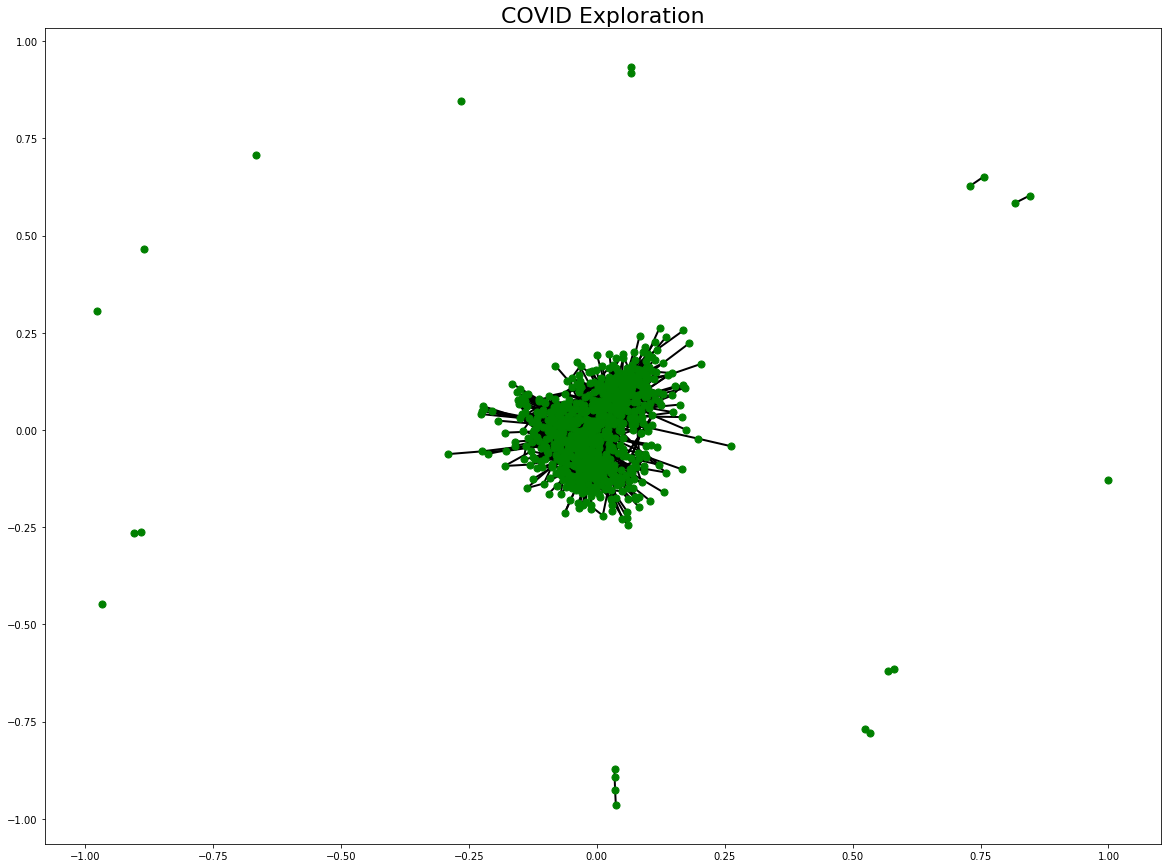

In [448]:
pos = nx.spring_layout(G)

fig, ax = plt.subplots(figsize=(20, 15))
plt.title("COVID Exploration", fontsize=22, fontname='DejaVu Sans')
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='green')
nx.draw_networkx_edges(G, pos, width=2.0)
plt.show()

## Degree Centrality
Measure number of incoming connections.

The higher the connection means the article is important.

[(939.0, 0.13399153737658673), (1221.0, 0.11142454160789844), (16801.0, 0.1071932299012694), (19538.0, 0.1071932299012694), (11423.0, 0.09873060648801128), (12444.0, 0.09732016925246827), (22464.0, 0.09732016925246827), (10197.0, 0.08603667136812412), (1673.0, 0.0846262341325811), (15480.0, 0.08180535966149506)]


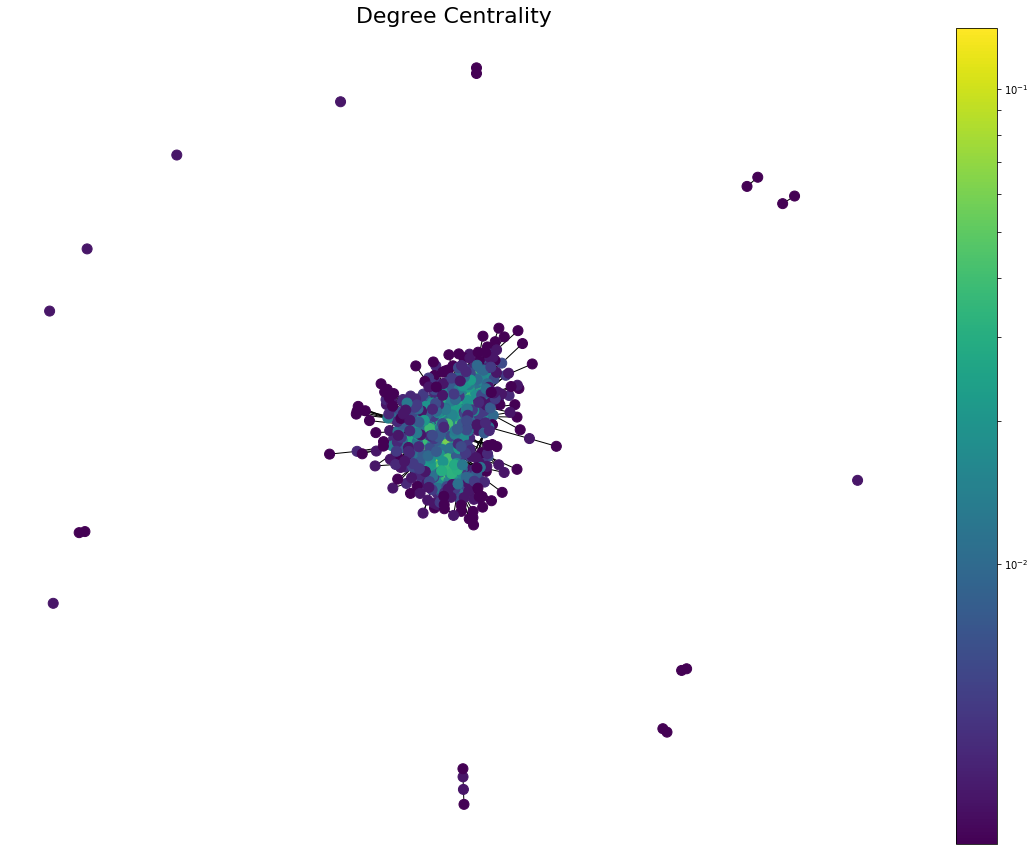

In [449]:
from collections import Counter
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline

# Function to plot the graphs for each centrality metric
def draw(G, pos, lista, listb, measure_name):
    fig, ax = plt.subplots(figsize=(20, 15))
    nodes=nx.draw_networkx_nodes(G, pos, node_size=100, cmap=plt.cm.viridis,node_color=lista,nodelist=listb)
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    edges=nx.draw_networkx_edges(G, pos)
    plt.title(measure_name, fontsize=22, fontname='DejaVu Sans')
    plt.colorbar(nodes)
    plt.axis('off')

dict_degree_centrality = nx.degree_centrality(G)
dict(Counter(dict_degree_centrality).most_common(10))

# dict_closeness_centrality = nx.closeness_centrality(G)
# dict(Counter(dict_closeness_centrality).most_common(10))

list_pos_values = []
for i in dict_degree_centrality.values():
    list_pos_values.append(i)

list_pos_keys=[]
for i in dict_degree_centrality.keys():
    list_pos_keys.append(i)
    
draw(G, pos, list_pos_values, list_pos_keys, 'Degree Centrality')
print(Counter(dict_degree_centrality).most_common(10))

In [435]:
# Looking at articles with the most importances
def view_articles(articles):
    keys = [item[0] for item in articles]
    degree_scores = [item[1] for item in articles]
    degreeCent_df = result_df.loc[keys]
    degreeCent_df['degree score'] = degree_scores
    return degreeCent_df.sort_values(by='degree score', ascending=False)

In [450]:
degreeCent_df = view_articles(Counter(dict_degree_centrality).most_common(10))
degreeCent_df

,title,abstract,content,score,degree score
939.0,Advances in the diagnosis of respiratory virus...,Background: Advances have been made in selecti...,Advances in the diagnosis of respiratory virus...,0.885020,0.133992
1221.0,Diagnostic Techniques: Microarrays.,Current techniques for viral detection and dis...,Diagnostic Techniques: Microarrays. Current te...,0.882357,0.111425
16801.0,Modernising epidemic science: enabling patient...,BACKGROUND: Emerging and epidemic infectious d...,Modernising epidemic science: enabling patient...,0.883646,0.107193
19538.0,Validation of the easyscreen flavivirus dengue...,BACKGROUND: The family flaviviridae and alphav...,Validation of the easyscreen flavivirus dengue...,0.882372,0.107193
11423.0,Surveillance strategy for early detection of u...,"New pathogens continue to emerge, and the incr...",Surveillance strategy for early detection of u...,0.881922,0.098731
12444.0,COVID-19: Real-time dissemination of scientifi...,Rapidly sharing scientific information is an e...,COVID-19: Real-time dissemination of scientifi...,0.881117,0.097320
22464.0,Harnessing the Digital Exhaust: Incorporating ...,The increasing availability of devices capable...,Harnessing the Digital Exhaust: Incorporating ...,0.880829,0.097320
10197.0,Diagnosis of human metapneumovirus and rhinovi...,Background: Adequate laboratory diagnosis of h...,Diagnosis of human metapneumovirus and rhinovi...,0.881931,0.086037
1673.0,Chapter 5 Integrated Polymerase Chain Reaction...,The tools available for both infectious diseas...,Chapter 5 Integrated Polymerase Chain Reaction...,0.894485,0.084626
15480.0,Plant-based solutions for veterinary immunothe...,An alarming increase in emergence of antibioti...,Plant-based solutions for veterinary immunothe...,0.883343,0.081805


In [451]:
for idx, row in degreeCent_df.iterrows():
    print(row['title'])
    print(row['abstract'])
    print()

Advances in the diagnosis of respiratory virus infections.
Background: Advances have been made in selecting sensitive cell lines for isolation, in early detection of respiratory virus growth in cells by rapid culture assays, in production of monoclonal antibodies to improve many tests such as immunofluorescence detection of virus antigens in nasopharyngeal aspirates, in highly sensitive antigen detections by time-resolved fluoroimmunoassays (TR-FIAs) and biotin-enzyme immunoassays (BIOTH-E), and, finally, in the polymerase chain reaction (PCR) detection of respiratory virus DNA or RNA in clinical specimens. All of these advances have contributed to new or improved possibilities for the diagnosis of respiratory virus infections. Objectives and study design: This review summarizes our experiences during the last 15 years in the development of diagnostic tests for respiratory virus infections, and in use of these tests in daily diagnostic work and in epidemiological studies. Results: Immu

## Closeness Centrality

/home/asuspro/anaconda3/envs/nlp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/asuspro/anaconda3/envs/nlp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


[(939.0, 0.4024683504365193), (1221.0, 0.4002902294780535), (2040.0, 0.3983738190436881), (1673.0, 0.3983738190436881), (11910.0, 0.39412827212670387), (11423.0, 0.393662123963337), (22170.0, 0.39020085089214707), (12309.0, 0.3827962344002317), (10011.0, 0.38017284501542137), (1216.0, 0.38017284501542137)]


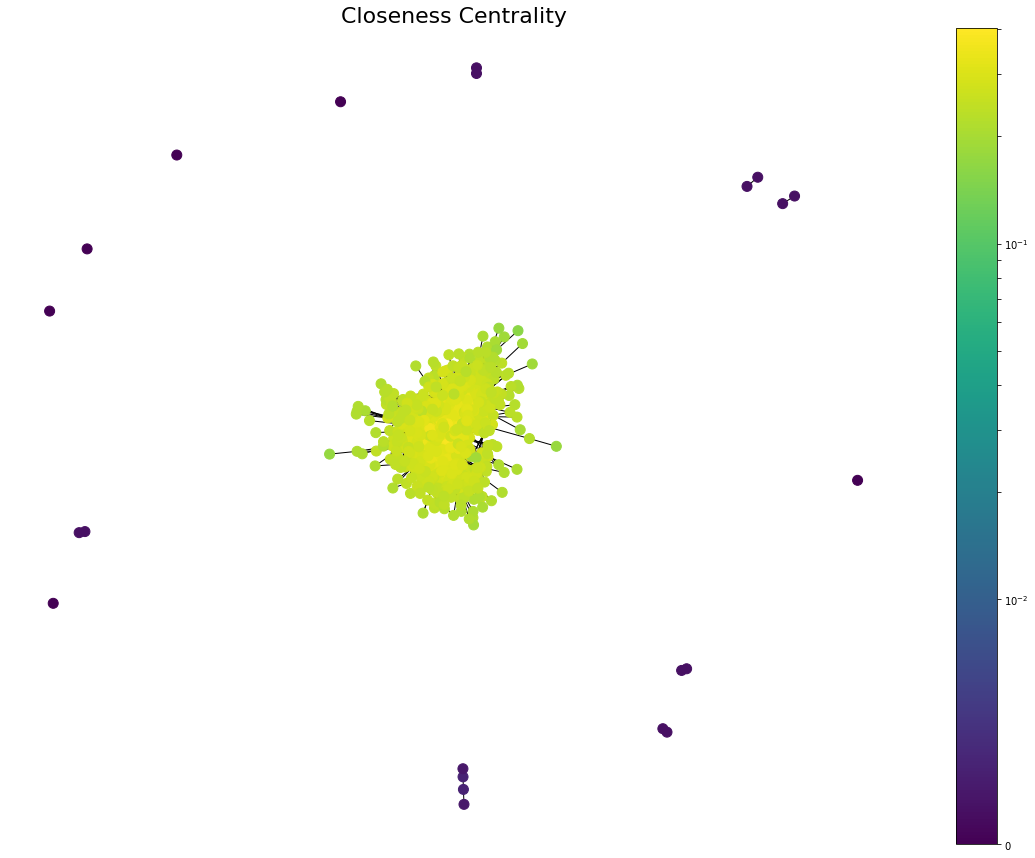

In [452]:
dict_closeness_centrality = nx.closeness_centrality(G)
dict(Counter(dict_closeness_centrality).most_common(10))

list_pos_values = []
for i in dict_closeness_centrality.values():
    list_pos_values.append(i)

list_pos_keys=[]
for i in dict_closeness_centrality.keys():
    list_pos_keys.append(i)
    
draw(G, pos, list_pos_values, list_pos_keys, 'Closeness Centrality')
print(Counter(dict_closeness_centrality).most_common(10))

In [453]:
closenessCent_df = view_articles(Counter(dict_closeness_centrality).most_common(10))
closenessCent_df

,title,abstract,content,score,degree score
939.0,Advances in the diagnosis of respiratory virus...,Background: Advances have been made in selecti...,Advances in the diagnosis of respiratory virus...,0.885020,0.402468
1221.0,Diagnostic Techniques: Microarrays.,Current techniques for viral detection and dis...,Diagnostic Techniques: Microarrays. Current te...,0.882357,0.400290
2040.0,Chapter 5 Laboratory diagnosis of viral infect...,Since the last Handbook of Clinical Neurology ...,Chapter 5 Laboratory diagnosis of viral infect...,0.887307,0.398374
1673.0,Chapter 5 Integrated Polymerase Chain Reaction...,The tools available for both infectious diseas...,Chapter 5 Integrated Polymerase Chain Reaction...,0.894485,0.398374
11910.0,Evolving status of the 2019 novel coronavirus ...,The novel coronavirus (nCoV-2019) outbreak in ...,Evolving status of the 2019 novel coronavirus ...,0.887876,0.394128
11423.0,Surveillance strategy for early detection of u...,"New pathogens continue to emerge, and the incr...",Surveillance strategy for early detection of u...,0.881922,0.393662
22170.0,Practical Guidance for Clinical Microbiology L...,Respiratory viral infections are associated wi...,Practical Guidance for Clinical Microbiology L...,0.892269,0.390201
12309.0,"Bacteriophage Based Biosensors: Trends, Outcom...",Foodborne pathogens are one of the main concer...,"Bacteriophage Based Biosensors: Trends, Outcom...",0.884308,0.382796
10011.0,Molecular diagnostic techniques.,Clinical microbiology laboratories increasingl...,Molecular diagnostic techniques. Clinical micr...,0.886297,0.380173
1216.0,Diagnostic Techniques: Serological and Molecul...,Virus laboratory diagnostics has an increasing...,Diagnostic Techniques: Serological and Molecul...,0.883498,0.380173


## Eigenvector Centrality

/home/asuspro/anaconda3/envs/nlp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/asuspro/anaconda3/envs/nlp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


[(16801.0, 0.2001066787715786), (12444.0, 0.19649112877463146), (22464.0, 0.19208010264925818), (11423.0, 0.17525861344405347), (22029.0, 0.16757091987549477), (10645.0, 0.16385257029563685), (6407.0, 0.1520523930713714), (20847.0, 0.14587548365974146), (1974.0, 0.14303387439152415), (14584.0, 0.14236492874985324)]


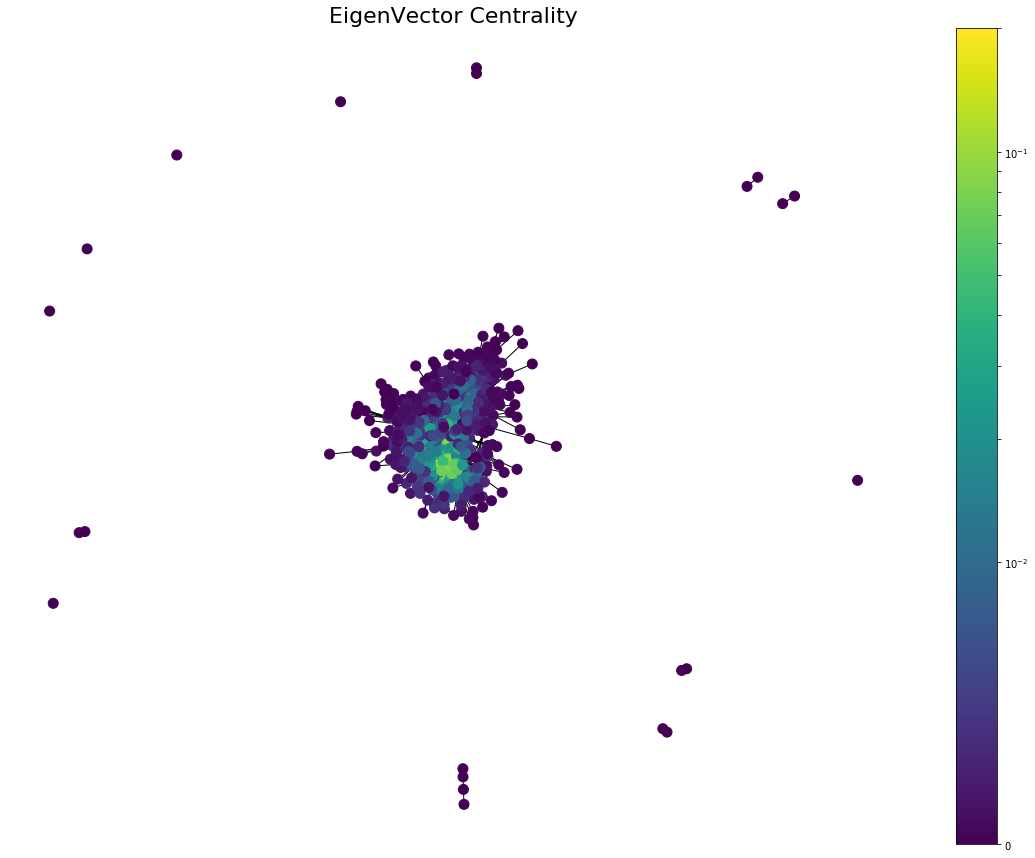

In [454]:
dict_eigenvector_centrality = nx.eigenvector_centrality(G)
dict(Counter(dict_eigenvector_centrality).most_common(10))

list_pos_values = []
for i in dict_eigenvector_centrality.values():
    list_pos_values.append(i)

list_pos_keys=[]
for i in dict_eigenvector_centrality.keys():
    list_pos_keys.append(i)
    
draw(G, pos, list_pos_values, list_pos_keys, 'EigenVector Centrality')
print(Counter(dict_eigenvector_centrality).most_common(10))

In [455]:
eigenCent_df = view_articles(Counter(dict_eigenvector_centrality).most_common(10))
eigenCent_df

,title,abstract,content,score,degree score
16801.0,Modernising epidemic science: enabling patient...,BACKGROUND: Emerging and epidemic infectious d...,Modernising epidemic science: enabling patient...,0.883646,0.200107
12444.0,COVID-19: Real-time dissemination of scientifi...,Rapidly sharing scientific information is an e...,COVID-19: Real-time dissemination of scientifi...,0.881117,0.196491
22464.0,Harnessing the Digital Exhaust: Incorporating ...,The increasing availability of devices capable...,Harnessing the Digital Exhaust: Incorporating ...,0.880829,0.192080
11423.0,Surveillance strategy for early detection of u...,"New pathogens continue to emerge, and the incr...",Surveillance strategy for early detection of u...,0.881922,0.175259
22029.0,Use of Big Data and Machine Learning Methods i...,"BACKGROUND: Digital health programs, which enc...",Use of Big Data and Machine Learning Methods i...,0.881042,0.167571
10645.0,"The Past, Present, and Future of Simulation-ba...",The pediatric emergency medicine (PEM) environ...,"The Past, Present, and Future of Simulation-ba...",0.884528,0.163853
6407.0,Simulation models for transmission of health c...,Background Health care–associated infections (...,Simulation models for transmission of health c...,0.882524,0.152052
20847.0,Importance of diagnostics in epidemic and pand...,Diagnostics are fundamental for successful out...,Importance of diagnostics in epidemic and pand...,0.882362,0.145875
1974.0,21 Microbiology.,The management and containment of many treatab...,21 Microbiology. The management and containmen...,0.885961,0.143034
14584.0,Nanorobot Hardware Architecture for Medical De...,This work presents a new approach with details...,Nanorobot Hardware Architecture for Medical De...,0.892572,0.142365


In [456]:
for idx, row in eigenCent_df.iterrows():
    print(row['title'])
    print(row['abstract'])
    print()

Modernising epidemic science: enabling patient-centred research during epidemics.
BACKGROUND: Emerging and epidemic infectious disease outbreaks are a significant public health problem and global health security threat. As an outbreak begins, epidemiological investigations and traditional public health responses are generally mounted very quickly. However, patient-centred research is usually not prioritised when planning and enacting the response. Instead, the clinical research response occurs subsequent to and separate from the public health response, and is inadequate for evidence-based decision-making at the bedside or in the offices of public health policymakers. DISCUSSION: The deficiencies of the clinical research response to severe acute respiratory syndrome, pandemic influenza, Middle East respiratory syndrome coronavirus and Ebola virus demonstrate that current research models do not adequately inform and improve the quality of clinical care or public health response. Three su

## Betweeness Centrality

In [77]:
from multiprocessing import Pool
import itertools

In [457]:
def partitions(nodes, n):
    "Partitions the nodes into n subsets"
    nodes_iter = iter(nodes)
    while True:
        partition = tuple(itertools.islice(nodes_iter,n))
        if not partition:
            return
        yield partition
        
def btwn_pool(G_tuple):
    return nx.betweenness_centrality_source(*G_tuple)

def partitions(nodes, n):
    "Partitions the nodes into n subsets"
    nodes_iter = iter(nodes)
    while True:
        partition = tuple(itertools.islice(nodes_iter,n))
        if not partition:
            return
        yield partition
        
# To begin the parallel computation, we initialize a Pool object with the
# number of available processors on our hardware. We then partition the
# network based on the size of the Pool object (the size is equal to the 
# number of available processors). 
def between_parallel(G, processes = None):
    p = Pool(processes=processes)
    part_generator = 4*len(p._pool)
    node_partitions = list(partitions(G.nodes(), int(len(G)/part_generator)))
    num_partitions = len(node_partitions)
 
    #Next, we pass each processor a copy of the entire network and 
    #compute #the betweenness centrality for each vertex assigned to the 
    #processor.
 
    bet_map = p.map(btwn_pool,
                    zip([G]*num_partitions,
                        [True]*num_partitions,
                        [None]*num_partitions,
                        node_partitions))
 
    #Finally, we collect the betweenness centrality calculations from each 
    #pool and aggregate them together to compute the overall betweenness 
    #centrality score for each vertex in the network.
 
    bt_c = bet_map[0]
    for bt in bet_map[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

Finding Betweenness Centrality in parallel...


/home/asuspro/anaconda3/envs/nlp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/asuspro/anaconda3/envs/nlp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


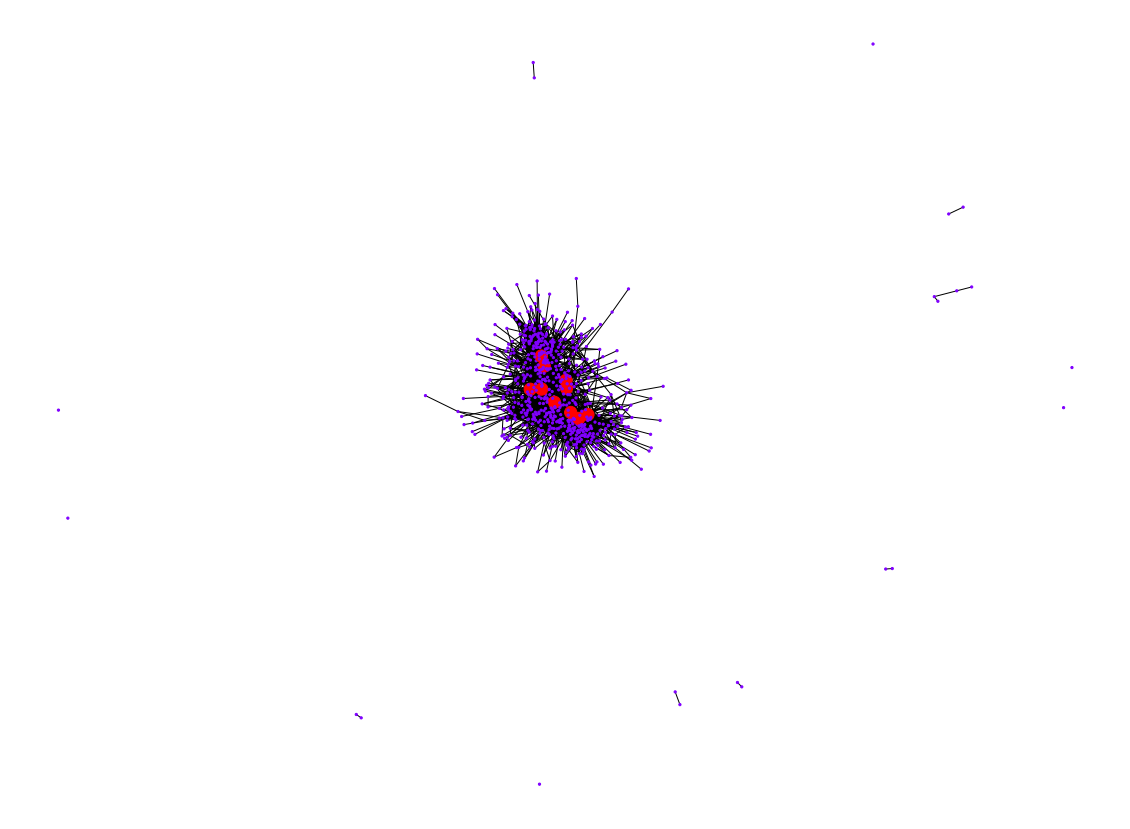

In [458]:
# print(nx.info(G))
print("Finding Betweenness Centrality in parallel...")

#Create network layout for visualizations
spring_pos = nx.spring_layout(G)
bt = between_parallel(G)
top = 10

max_nodes = sorted(bt.items(), key=lambda k:k[1])[-top:]
bt_values = [5]*len(G.nodes())
bt_colors = [0]*len(G.nodes())

max_ids = [i[0] for i in max_nodes]
for idx, eventid in enumerate(bt.keys()):
    if eventid in max_ids:
        bt_values[idx] = 150
        bt_colors[idx] = 2

fig, ax = plt.subplots(figsize=(20, 15))
plt.axis("off")
nx.draw_networkx(G, pos = spring_pos, cmap = plt.get_cmap("rainbow"), node_color = bt_colors, node_size = bt_values, with_labels = False)

In [459]:
result_df.loc[list(max_ids)]

,title,abstract,content,score
24811.0,Novel approaches and challenges to treatment o...,Existing and emerging viral CNS infections are...,Novel approaches and challenges to treatment o...,0.882476
19538.0,Validation of the easyscreen flavivirus dengue...,BACKGROUND: The family flaviviridae and alphav...,Validation of the easyscreen flavivirus dengue...,0.882372
16801.0,Modernising epidemic science: enabling patient...,BACKGROUND: Emerging and epidemic infectious d...,Modernising epidemic science: enabling patient...,0.883646
11423.0,Surveillance strategy for early detection of u...,"New pathogens continue to emerge, and the incr...",Surveillance strategy for early detection of u...,0.881922
12003.0,Practical recommendations for critical care an...,A global health emergency has been declared by...,Practical recommendations for critical care an...,0.881772
11910.0,Evolving status of the 2019 novel coronavirus ...,The novel coronavirus (nCoV-2019) outbreak in ...,Evolving status of the 2019 novel coronavirus ...,0.887876
1673.0,Chapter 5 Integrated Polymerase Chain Reaction...,The tools available for both infectious diseas...,Chapter 5 Integrated Polymerase Chain Reaction...,0.894485
22170.0,Practical Guidance for Clinical Microbiology L...,Respiratory viral infections are associated wi...,Practical Guidance for Clinical Microbiology L...,0.892269
1221.0,Diagnostic Techniques: Microarrays.,Current techniques for viral detection and dis...,Diagnostic Techniques: Microarrays. Current te...,0.882357
939.0,Advances in the diagnosis of respiratory virus...,Background: Advances have been made in selecti...,Advances in the diagnosis of respiratory virus...,0.885020


In [460]:
for idx, row in result_df.loc[list(max_ids)].iterrows():
    print(row['title'])
    print(row['abstract'])
    print()

Novel approaches and challenges to treatment of CNS viral infections.
Existing and emerging viral CNS infections are major sources of human morbidity and mortality. Treatments of proven efficacy are currently limited predominantly to herpesviruses and human immunodeficiency virus. Development of new therapies has been hampered by the lack of appropriate animal model systems for some important viruses and by the difficulty in conducting human clinical trials for diseases that may be rare, or in the case of arboviral infections, often have variable seasonal and geographic incidence. Nonetheless, many novel approaches to antiviral therapy are available including candidate thiazolide and purazinecarboxamide derivatives with potential broad-spectrum antiviral efficacy. New herpesvirus drugs include viral helicase-primase and terminase inhibitors. The use of antisense oligonucleotides and other strategies to interfere with viral RNA translation has shown efficacy in experimental models of CN

# Answering the 2nd question using EgienVector

In [417]:
result_df = search_doc("Movement control strategies to prevent secondary transmission, health care and community settings", context="pneumonia, medical", top_n=1500)
result_df

,title,abstract,content,score
21171,Epidemiology and prevention of pediatric viral...,Nosocomial viral respiratory infections cause ...,Epidemiology and prevention of pediatric viral...,0.892446
11291,Morbidity and mortality amongst Indian Hajj pi...,"The Hajj, a mass-gathering of over 3.5-million...",Morbidity and mortality amongst Indian Hajj pi...,0.884564
21093,Year in review 2005: Critical Care – Respirolo...,We summarize all original research in the fiel...,Year in review 2005: Critical Care – Respirolo...,0.880617
2566,Acute Febrile Respiratory Illness in the ICU.,Acute febrile respiratory illness (FRI) leadin...,Acute Febrile Respiratory Illness in the ICU. ...,0.878746
7336,Épidémiologie de l'asthme grave.,Summary Prevalence of severe acute asthma can ...,Épidémiologie de l'asthme grave. Summary Preva...,0.877843
...,...,...,...,...
12408,Respiratory support for severe 2019-nCoV pneum...,Respiratory support is a very important techni...,Respiratory support for severe 2019-nCoV pneum...,0.830889
19648,Molecular Diagnosis of Pneumonia Using Multipl...,"BACKGROUND: In Morocco, pediatric pneumonia re...",Molecular Diagnosis of Pneumonia Using Multipl...,0.830885
4233,Infectious causes of embryonic and fetal morta...,The purpose of this review is to summarize bac...,Infectious causes of embryonic and fetal morta...,0.830885
20339,Co‐infections with Respiratory Viruses in Dogs...,BACKGROUND: Bacterial pneumonia (BP) is an inf...,Co‐infections with Respiratory Viruses in Dogs...,0.830883


## Computer distance matrix on all selected documents

In [418]:
dis_matrix = []

# Filter selected vectors
df_result_vectors = df_vectors.iloc[result_df.index]

# Compute similarity vector matrix against each document
for idx, row in tqdm_notebook(df_result_vectors.iterrows(), total=len(df_result_vectors)):
    row = list(row)
    result = model.cosine_similarities(row, df_result_vectors)
    dis_matrix.append(result)
    
# Scale the result 
min_max_scaler = preprocessing.MinMaxScaler()
dis_matrix = min_max_scaler.fit_transform(dis_matrix)
dis_matrix_df = pd.DataFrame(dis_matrix)

# Adding IDs for easy reference
dis_matrix_df.columns = result_df.index
dis_matrix_df.insert(0, 'id', result_df.index)
dis_matrix_df

,id,21171,11291,21093,2566,7336,12412,4336,4661,10021,...,17230,22505,6134,21183,10240,12408,19648,4233,20339,34413
0,21171,1.000000,0.649105,0.638713,0.833229,0.717967,0.737457,0.630929,0.672983,0.655526,...,0.616028,0.551601,0.642162,0.620544,0.722969,0.664146,0.653175,0.714055,0.640926,0.717418
1,11291,0.629469,1.000000,0.700914,0.727682,0.727619,0.634514,0.838314,0.696547,0.734508,...,0.756257,0.404026,0.745268,0.725509,0.701218,0.642369,0.583113,0.710300,0.596386,0.722999
2,21093,0.629993,0.709928,1.000000,0.688994,0.623294,0.590788,0.721045,0.724171,0.650966,...,0.682188,0.448433,0.707523,0.684434,0.563377,0.601204,0.557452,0.650011,0.522793,0.638772
3,2566,0.824195,0.728145,0.679875,1.000000,0.781870,0.890965,0.730163,0.763515,0.749037,...,0.723536,0.608279,0.782369,0.659755,0.778861,0.781890,0.798854,0.789972,0.701433,0.800278
4,7336,0.671875,0.699898,0.572058,0.759261,1.000000,0.708554,0.713820,0.613193,0.644632,...,0.691308,0.509202,0.703830,0.661448,0.641772,0.642884,0.630126,0.657262,0.543322,0.632107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,12408,0.555285,0.551544,0.484385,0.726033,0.593555,0.696733,0.615372,0.710918,0.615008,...,0.684688,0.414054,0.734178,0.641279,0.663518,1.000000,0.663986,0.655062,0.526896,0.754494
1496,19648,0.648932,0.600375,0.562595,0.806855,0.678193,0.783349,0.596209,0.728424,0.638834,...,0.667977,0.593064,0.775794,0.645673,0.801776,0.743134,1.000000,0.757925,0.736089,0.791301
1497,4233,0.648717,0.662965,0.580173,0.755239,0.638093,0.611789,0.694833,0.687418,0.687809,...,0.813554,0.493479,0.839635,0.703410,0.746613,0.679976,0.706207,1.000000,0.623204,0.859275
1498,20339,0.602232,0.576586,0.483828,0.686253,0.565173,0.654438,0.574156,0.566579,0.643629,...,0.561522,0.576749,0.649187,0.579444,0.791812,0.604205,0.711183,0.660236,1.000000,0.684700


In [419]:
# Only look at single side of the matric
copy_df = dis_matrix_df.copy()
for idx, row in copy_df.iterrows():
    if idx > 0:
        row[1:idx+1] = 0
        copy_df.iloc[idx] = row
        
dis_matrix_df = copy_df
dis_matrix_df

,id,21171,11291,21093,2566,7336,12412,4336,4661,10021,...,17230,22505,6134,21183,10240,12408,19648,4233,20339,34413
0,21171.0,1.0,0.649105,0.638713,0.833229,0.717967,0.737457,0.630929,0.672983,0.655526,...,0.616028,0.551601,0.642162,0.620544,0.722969,0.664146,0.653175,0.714055,0.640926,0.717418
1,11291.0,0.0,1.000000,0.700914,0.727682,0.727619,0.634514,0.838314,0.696547,0.734508,...,0.756257,0.404026,0.745268,0.725509,0.701218,0.642369,0.583113,0.710300,0.596386,0.722999
2,21093.0,0.0,0.000000,1.000000,0.688994,0.623294,0.590788,0.721045,0.724171,0.650966,...,0.682188,0.448433,0.707523,0.684434,0.563377,0.601204,0.557452,0.650011,0.522793,0.638772
3,2566.0,0.0,0.000000,0.000000,1.000000,0.781870,0.890965,0.730163,0.763515,0.749037,...,0.723536,0.608279,0.782369,0.659755,0.778861,0.781890,0.798854,0.789972,0.701433,0.800278
4,7336.0,0.0,0.000000,0.000000,0.000000,1.000000,0.708554,0.713820,0.613193,0.644632,...,0.691308,0.509202,0.703830,0.661448,0.641772,0.642884,0.630126,0.657262,0.543322,0.632107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,12408.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.663986,0.655062,0.526896,0.754494
1496,19648.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.757925,0.736089,0.791301
1497,4233.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.623204,0.859275
1498,20339.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.684700


## Forming nodes and edges

In [421]:
threshold = 0.89
connections = {}
id_list = dis_matrix_df['id']

for _, row in tqdm_notebook(dis_matrix_df.iterrows(), total=len(dis_matrix_df)):
    connectToIds = []
    cur_id = int(row.values[0])

    # filter out edge that met our threshold
    for idx, v in zip(id_list, row.values[1:]):
        if v < 1.0 and v > threshold:
            connectToIds.append(idx)
            
    # matching cur id to connected id
    connections[cur_id] = connectToIds 
    
    
G = nx.Graph()
G.clear()

for achorEvent in tqdm_notebook(connections.keys()):
    for _, eventid in enumerate(connections[achorEvent]):
        # Adding by nodes and edges
        G.add_edge(achorEvent, eventid)
        
print(nx.info(G))


Name: 
Type: Graph
Number of nodes: 984
Number of edges: 6395
Average degree:  12.9980


/home/asuspro/anaconda3/envs/nlp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/asuspro/anaconda3/envs/nlp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


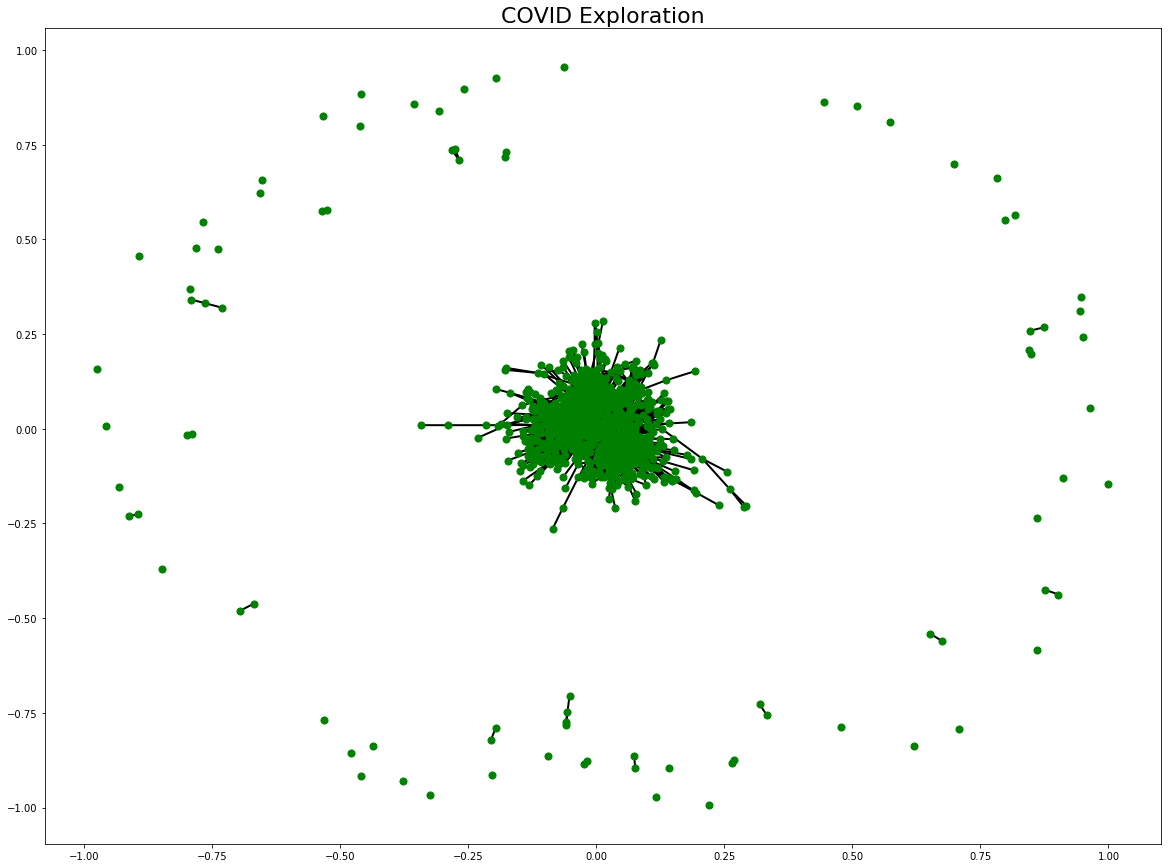

In [422]:
pos = nx.spring_layout(G)

fig, ax = plt.subplots(figsize=(20, 15))
plt.title("COVID Exploration", fontsize=22, fontname='DejaVu Sans')
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='green')
nx.draw_networkx_edges(G, pos, width=2.0)
plt.show()

## EigenVector Centrality

[(12003.0, 0.2315611962615462), (34782.0, 0.18500973624513734), (33661.0, 0.18463656501207473), (13453.0, 0.18124766369049408), (20333.0, 0.17124073347492116), (16801.0, 0.16581810702387406), (27784.0, 0.16315712673652025), (28632.0, 0.15763915997912945), (1936.0, 0.1568154868348927), (12444.0, 0.14065517722526263)]


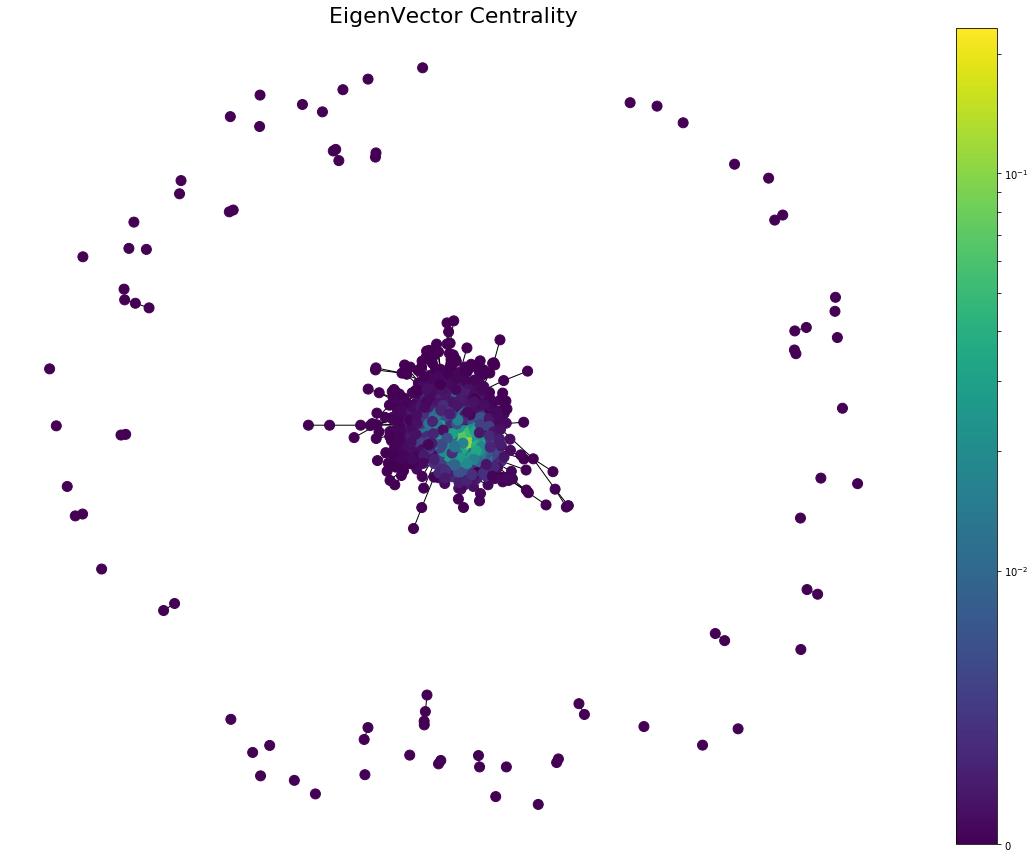

In [423]:
dict_eigenvector_centrality = nx.eigenvector_centrality(G)
dict(Counter(dict_eigenvector_centrality).most_common(10))

list_pos_values = []
for i in dict_eigenvector_centrality.values():
    list_pos_values.append(i)

list_pos_keys=[]
for i in dict_eigenvector_centrality.keys():
    list_pos_keys.append(i)
    
draw(G, pos, list_pos_values, list_pos_keys, 'EigenVector Centrality')
print(Counter(dict_eigenvector_centrality).most_common(10))

In [424]:
eigenCent_df = view_articles(Counter(dict_eigenvector_centrality).most_common(10))
eigenCent_df

,title,abstract,content,score,degree score
12003,Practical recommendations for critical care an...,A global health emergency has been declared by...,Practical recommendations for critical care an...,0.848635,0.231561
34782,Experiences and challenges in the health prote...,BACKGROUND: Health care workers are at the fro...,Experiences and challenges in the health prote...,0.841536,0.185010
33661,Timely mental health care for the 2019 novel c...,The 2019 novel coronavirus (2019-nCoV) pneumon...,Timely mental health care for the 2019 novel c...,0.840937,0.184637
13453,Facing the threat of influenza pandemic - role...,"The 2009 pandemic of H1N1 influenza, compounde...",Facing the threat of influenza pandemic - role...,0.839587,0.181248
20333,Critical role of ethics in clinical management...,The devastation caused by the Ebola virus dise...,Critical role of ethics in clinical management...,0.833553,0.171241
16801,Modernising epidemic science: enabling patient...,BACKGROUND: Emerging and epidemic infectious d...,Modernising epidemic science: enabling patient...,0.834854,0.165818
27784,Integrating Public Health and Primary Care.,PURPOSE: Improved health and social outcomes w...,Integrating Public Health and Primary Care. PU...,0.831027,0.163157
28632,Perspectives on emerging zoonotic disease rese...,Zoonoses are fundamental determinants of commu...,Perspectives on emerging zoonotic disease rese...,0.833406,0.157639
1936,50 Infectious Disease Considerations for the O...,The risk of infection transmission by anesthes...,50 Infectious Disease Considerations for the O...,0.842728,0.156815
12444,COVID-19: Real-time dissemination of scientifi...,Rapidly sharing scientific information is an e...,COVID-19: Real-time dissemination of scientifi...,0.835166,0.140655


In [425]:
for idx, row in eigenCent_df.iterrows():
    print(row['title'])
    print(row['abstract'])
    print()

Practical recommendations for critical care and anesthesiology teams caring for novel coronavirus (2019-nCoV) patients.
A global health emergency has been declared by the World Health Organization as the 2019-nCoV outbreak spreads across the world, with confirmed patients in Canada. Patients infected with 2019-nCoV are at risk for developing respiratory failure and requiring admission to critical care units. While providing optimal treatment for these patients, careful execution of infection control measures is necessary to prevent nosocomial transmission to other patients and to healthcare workers providing care. Although the exact mechanisms of transmission are currently unclear, human-to-human transmission can occur, and the risk of airborne spread during aerosol-generating medical procedures remains a concern in specific circumstances. This paper summarizes important considerations regarding patient screening, environmental controls, personal protective equipment, resuscitation mea